In [44]:
# Digital Surface Model (DSM), Digital Elevation Models (DEM) and the Canopy Height Model (CHM) are the most common 
# raster format lidar derived data products. One way to derive a CHM is to take the difference between the digital
# surface model (DSM, tops of trees, buildings and other objects) and the Digital Terrain Model (DTM, ground level).
# The CHM represents the actual height of trees, buildings, etc. with the influence of ground elevation removed.

# Use geopandas for vector data and xarray for raster data
import geopandas as gpd
import rioxarray as rxr
import os
import matplotlib.pyplot as plt
import earthpy.plot as ep
import numpy as np
from rasterio.plot import plotting_extent

import earthpy as et

In [5]:
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

dtm_pre_arr = rxr.open_rasterio(dem_pre_path)

# An xarray is another type of array that is specifically built to contain spatial metadata
# Contains a few functions that are useful for dealing with spatial data, such as band information, etc.
dtm_pre_arr

<xarray.DataArray (band: 1, y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
# When you open raster data using xarray or rioxarray you are creating an xarray.DataArray. The. DataArray object stores the:

#     raster data in a numpy array format
#     spatial metadata including the CRS, spatial extent of the object
#     and any metadata

# View the Coordinate Reference System (CRS) & spatial extent
print("The CRS for this data is:", dtm_pre_arr.rio.crs)
print("The spatial extent is:", dtm_pre_arr.rio.bounds())
print("The nodata is:", dtm_pre_arr.rio.nodata)

The CRS for this data is: EPSG:32613
The spatial extent is: (472000.0, 4434000.0, 476000.0, 4436000.0)
The nodata is: -3.4028235e+38


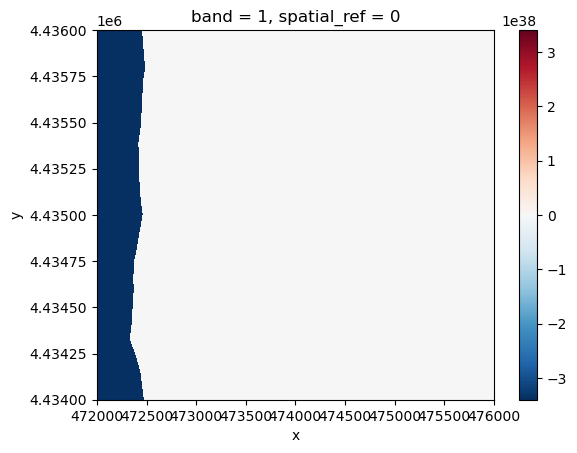

In [8]:
# You can plot it similar to geopandas
dtm_pre_arr.plot();

(array([ 842272.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 7157728.]),
 array([-3.40282347e+38, -3.06254122e+38, -2.72225877e+38, -2.38197633e+38,
        -2.04169408e+38, -1.70141173e+38, -1.36112939e+38, -1.02084704e+38,
        -6.80564693e+37, -3.40282347e+37,  2.08742993e+03]),
 <BarContainer object of 10 artists>)

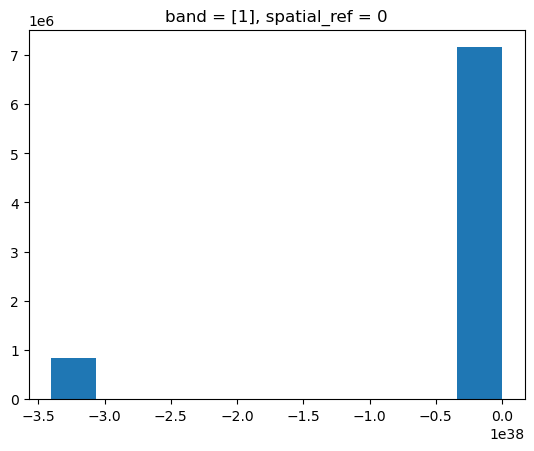

In [9]:
# The image above is clearly wrong - from the legend, its clear that hte nodata values are significantly skewing the 
# visualization of the image

# Can more clearly see this using
dtm_pre_arr.plot.hist()

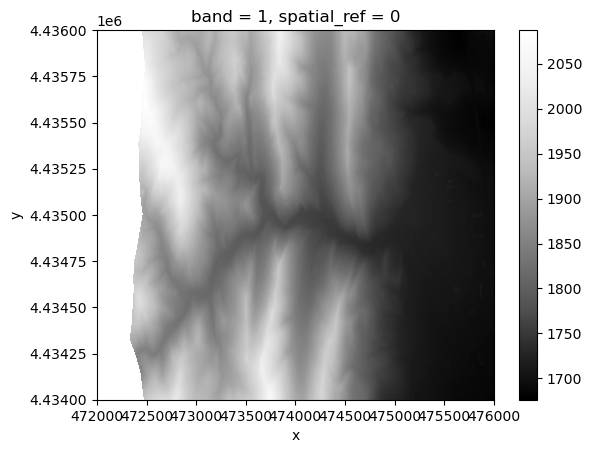

In [12]:
# To fix this, load in the data with the masked = True argument
# In addition, note that reading it in like this will lead to a 2D array with "1 band", i.e. a 3D array
# this can be an issue sometimes, so squeeze the data
dtm_masked = rxr.open_rasterio(dem_pre_path, masked = True).squeeze()

import matplotlib.pyplot as plt
f, ax = plt.subplots()

dtm_masked.plot(ax = ax, cmap = "Greys_r");

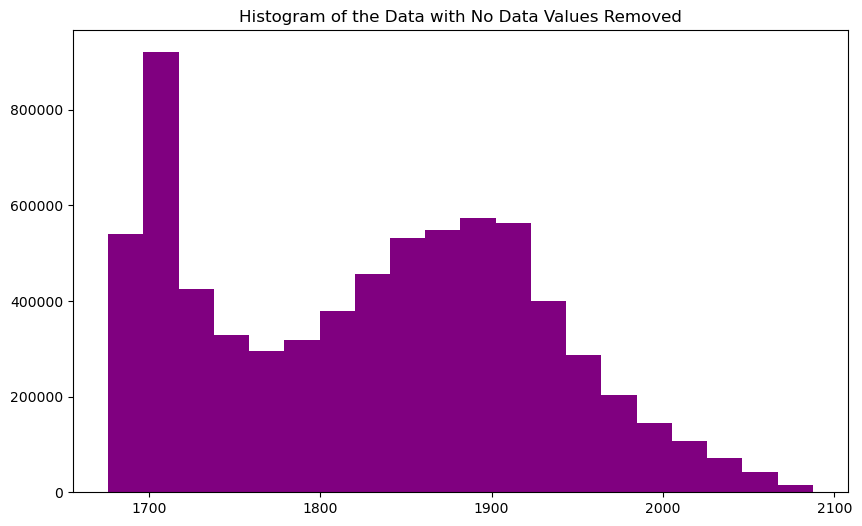

In [14]:
# Histogram has also changed
f, ax = plt.subplots(figsize=(10, 6))

dtm_masked.plot.hist(color="purple",
                      bins=20)

ax.set_title("Histogram of the Data with No Data Values Removed")
plt.show()

In [16]:
# All numpy functions work on xarrays:
import numpy as np

# note that you have to explicitly call the .data bit of the xarray, since there are other bits in there as well
print("The minimum raster value is: ", np.nanmin(dtm_masked.data))
print("The maximum raster value is: ", np.nanmax(dtm_masked.data))

The minimum raster value is:  1676.21
The maximum raster value is:  2087.43


In [17]:
# Vector and raster data can be plotted together
site_bound_path = os.path.join("colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")

site_bound_shp = gpd.read_file(site_bound_path)

site_bound_shp

id                                           geometry
0   1  POLYGON ((472510.465 4436000.000, 476009.764 4...

(472000.0, 476210.9883720931, 4434000.0, 4436000.0)

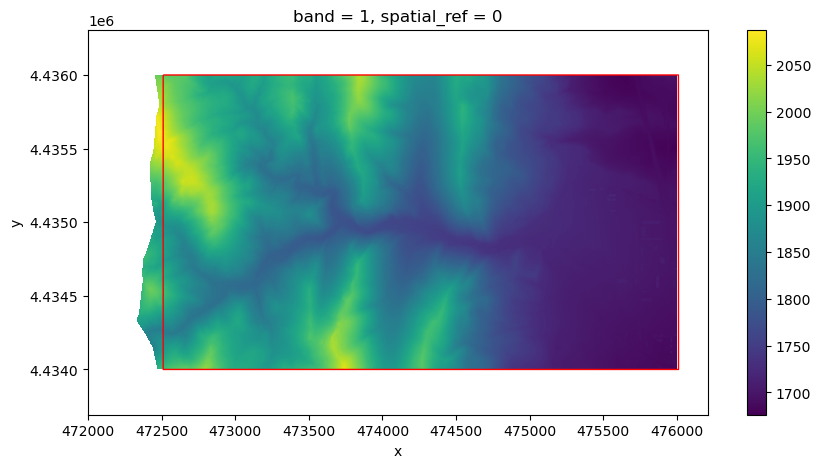

In [21]:
f, ax = plt.subplots(figsize=(10, 5))

dtm_masked.plot(ax = ax, cmap = "viridis")
site_bound_shp.plot(ax = ax, color = "none", edgecolor = "red")

# This makes it so that the x and y axis are equally spaced - good for making sure there is no stretching in the NS and EW 
# directions in maps
plt.axis("equal")

In [30]:
# Setting the CRS of a xarray object is relatively simple
# NOTE: This only works if the raster does NOT already have a CRS. 
# Be very careful about randomly assigning CRSs, as this can lead to some disastrous results
dtm_geographic = dtm_masked.rio.set_crs("EPSG:4326")

# You'll note that even though the crs object states that its EPSG:4326, the spatial ref of the xarray
# itself is still EPSG:32613 - specifically, the geotransform will still cause it plot as if it were EPSG:32613
# By printing bounds, you can see that it still uses units in meters
print(dtm_geographic.rio.crs)
print(dtm_geographic.rio.bounds())

# In general, try not to change the CRS of rasters - if possible, change the CRS of vector data instead.

EPSG:4326
(472000.0, 4434000.0, 476000.0, 4436000.0)


In [28]:
# There are a variety of CRS formats. proj4 is one of them:

# Convert to project string using earthpy
proj4 = et.epsg['32613']
print(proj4)

# +proj=utm The projection of the dataset. Your data are in Universal Transverse Mercator (UTM).
# +zone=18 The UTM projection divides up the world into zones, this element tells you which zone the data is in. 
#             Harvard Forest is in Zone 18.
# +datum=WGS84 The datum was used to define the center point of the projection. Your raster uses the WGS84 datum.
# +units=m This is the horizontal units that the data are in. Your units are meters.

+proj=utm +zone=13 +datum=WGS84 +units=m +no_defs


In [32]:
# What is the x and y resolution for your raster data?
dtm_masked.rio.resolution()

(1.0, -1.0)

In [36]:
# ### GEOTIFFS
# A GeoTIFF is a standard .tif or image file format that includes additional spatial (georeferencing) information embedded in the .tif file as tags. These embedded tags are called tif tags. These tags can include the following raster metadata:

#     Spatial Extent: What area does this dataset cover?
#     Coordinate reference system: What spatial projection / coordinate reference system is used to store the data? 
#         Will it line up with other data?
#     Resolution: The data appears to be in raster format. This means it is composed of pixels. 
#         What area on the ground does each pixel cover - i.e. What is its spatial resolution?
#     nodata value

# Define relative path to file
lidar_dem_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

pre_lidar_dem = rxr.open_rasterio(lidar_dem_path,
                                 masked=True)

# View metadata associated with the raster file
print("The crs of your data is:", pre_lidar_dem.rio.crs)
print("The nodatavalue of your data is:", pre_lidar_dem.rio.nodata)
print("The shape of your data is:", pre_lidar_dem.shape)
print("The spatial resolution for your data is:", pre_lidar_dem.rio.resolution())
print("The metadata for your data is:", pre_lidar_dem.attrs)
print("The data type for your data is:", pre_lidar_dem.dtype)

The crs of your data is: EPSG:32613
The nodatavalue of your data is: nan
The shape of your data is: (1, 2000, 4000)
The spatial resolution for your data is: (1.0, -1.0)
The metadata for your data is: {'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}
The data type for your data is: float32


In [37]:
# We can compare two rasters based on their metadata
# Define relative path to file
lidar_dsm_path = os.path.join("colorado-flood", 
                              "spatial",
                              "boulder-leehill-rd", 
                              "pre-flood", 
                              "lidar",
                              "pre_DSM.tif")

# Open lidar dsm
pre_lidar_dsm = rxr.open_rasterio(lidar_dsm_path)

# Check if the two rasters have the exact same bounds.
if pre_lidar_dem.rio.bounds() == pre_lidar_dsm.rio.bounds():
    print("Both datasets cover the same spatial extent.")

Both datasets cover the same spatial extent.


In [41]:
# Check if CRS is the same
print(pre_lidar_dem.rio.crs)
print(pre_lidar_dsm.rio.crs)

# In general, the rio accessor allows you find information in the src.profile object
print(pre_lidar_dem.rio.count)
print(pre_lidar_dsm.rio.count)

EPSG:32613
EPSG:32613
1
1


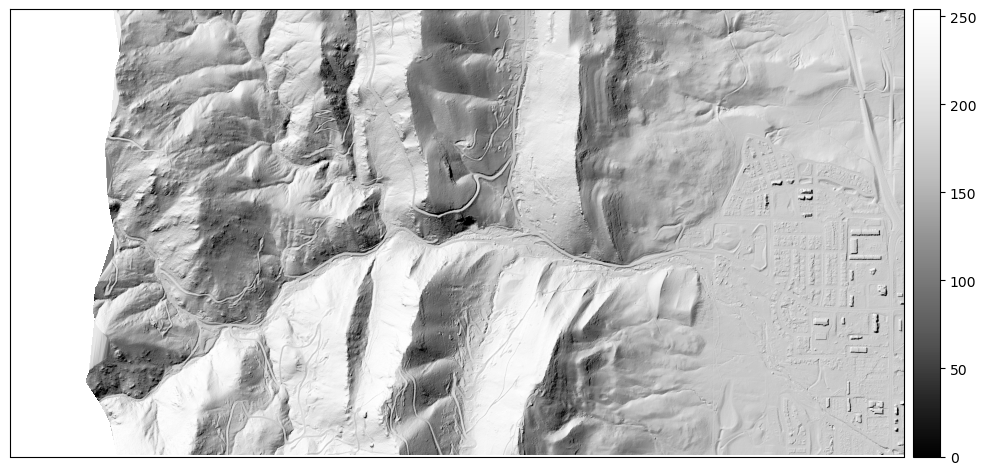

<Axes: >

In [43]:
### Plotting Hillshade
import earthpy.plot as ep

target_file = os.path.join("colorado-flood", 
                              "spatial",
                              "boulder-leehill-rd", 
                              "pre-flood", 
                              "lidar",
                              "pre_DTM_hill.tif")


dtm_hill = rxr.open_rasterio(target_file, masked = True)


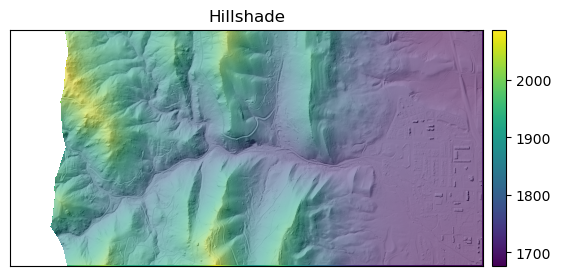

In [61]:
f, ax = plt.subplots()

# In general, it looks nicer if the colorful band is full opacity while the hillshade has a lower alpha
ep.plot_bands(dtm_masked, ax = ax, cmap = "viridis")
ep.plot_bands(dtm_hill, ax = ax, cmap = "Greys_r", cbar = False, alpha = 0.5)

ax.set_title("Hillshade");

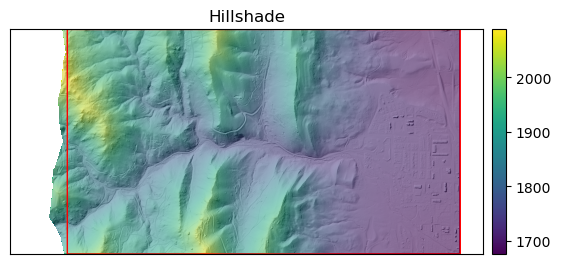

In [78]:
# To plot vector data on top of raster data using earthpy, we need to use plotting extents
# This is similar to using the transform argument in rio.plotting.show
from rasterio.plot import plotting_extent

# This is needed because plot_bands takes in arguments similar to imshow, which requires a different set of xmin, ymin, etc.
# compared to how .bounds() are reported in xarray
dtm_masked_extent = plotting_extent(dtm_masked, transform = dtm_masked.rio.transform())

# VERY IMPORTANT
# This requires a 2D IMAGE-  if you have a 3D array, use array[0]
dtm_hill_extent = plotting_extent(dtm_hill.squeeze(), transform = dtm_hill.rio.transform())

f, ax = plt.subplots()

# In general, it looks nicer if the colorful band is full opacity while the hillshade has a lower alpha
ep.plot_bands(dtm_masked, ax = ax, cmap = "viridis", extent = dtm_masked_extent)
ep.plot_bands(dtm_hill, ax = ax, cmap = "Greys_r", cbar = False, alpha = 0.5, extent = dtm_hill_extent)
site_bound_shp.plot(ax = ax, color = "none", edgecolor = "red")

ax.set_title("Hillshade");

In [80]:
# Compare pre- and post-flood raster

dtm_post = rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/post-flood/lidar/post_DTM.tif", masked = True)

dtm_post

<xarray.DataArray (band: 1, y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

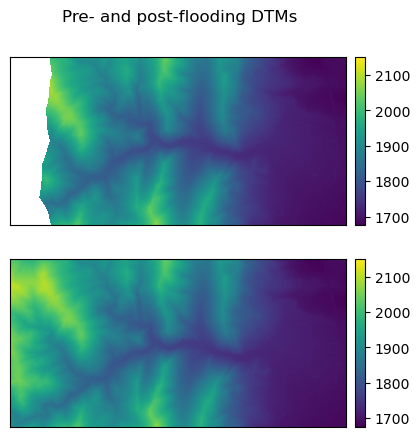

In [85]:
f, (ax1, ax2) = plt.subplots(nrows = 2)

vmin = 1675
vmax = 2150

# Set vmin and vmax using same 
ep.plot_bands(dtm_masked, ax = ax1, cmap = "viridis", vmin = vmin, vmax = vmax)
ep.plot_bands(dtm_post, ax = ax2, cmap = "viridis", vmin = vmin, vmax = vmax)

plt.suptitle("Pre- and post-flooding DTMs");

In [86]:
### Canopy Height Model

# The canopy height model (CHM) represents the HEIGHT of the trees. This is not an elevation value, rather it’s the
# height or distance between the ground and the top of the trees (or buildings or whatever object that the lidar system
# detected and recorded).

# Some canopy height models also include buildings, so you need to look closely at your data to make sure it was properly 
# cleaned before assuming it represents all trees!

# There are different ways to calculate a CHM. One easy way is to subtract the DEM from the DSM.

# DSM - DEM = CHM

# Recall - DSM = the raw height of the light returning to the LIDAR (tops of trees, etc.)
#          DEM = the ground elevation (ground level)

In [2]:
# First, make sure that the rasters have the same spatial resolution and extent

pre_DSM = rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DSM.tif", masked = True)
pre_DTM = rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif", masked = True)

print("DSM Reso", pre_DSM.rio.resolution())
print("DTM Reso", pre_DTM.rio.resolution())
print("DSM Extent", pre_DSM.rio.bounds())
print("DTM Extent", pre_DSM.rio.bounds())

DSM Reso (1.0, -1.0)
DTM Reso (1.0, -1.0)
DSM Extent (472000.0, 4434000.0, 476000.0, 4436000.0)
DTM Extent (472000.0, 4434000.0, 476000.0, 4436000.0)


In [3]:
# Note that pre_DSM and pre_DTM are 3D arrays
# Can still calculate CHM
pre_CHM = pre_DSM - pre_DTM

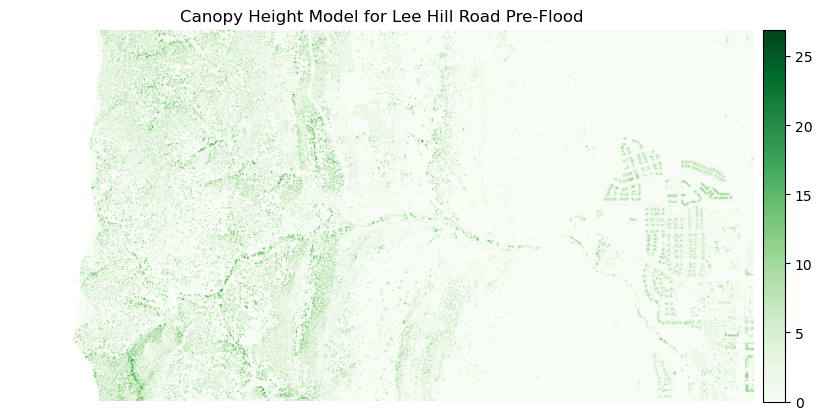

In [8]:
f, ax = plt.subplots(figsize=(10, 5))

# We can see that the graph shows trees in the catchment area to the west, and a settlement to the east
ax.set(title="Canopy Height Model for Lee Hill Road Pre-Flood")

ep.plot_bands(pre_CHM, cmap = "Greens", ax = ax)

ax.set_axis_off()
plt.show();

(array([5.992989e+06, 5.575860e+05, 3.684130e+05, 1.689750e+05,
        5.677500e+04, 1.157200e+04, 1.328000e+03, 9.000000e+01]),
 array([ 0.        ,  3.36625671,  6.73251343, 10.09877014, 13.46502686,
        16.83128357, 20.19754028, 23.563797  , 26.93005371]),
 <BarContainer object of 8 artists>)

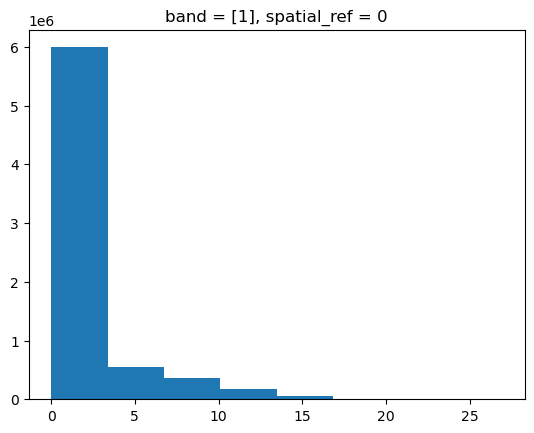

In [9]:
# We can use a histogram to see the range of values

# Looks like most of the land is <5m in height
pre_CHM.plot.hist(bins = 8)

In [4]:
# Create an output folder
data_path = os.path.join("colorado-flood",
                         "spatial",
                         "outputs")

if os.path.exists(data_path):
    print("The directory", data_path, "exists!")
else:
    os.makedirs(data_path)

The directory colorado-flood\spatial\outputs exists!


In [11]:
# Make sure that your output data has a crs & nodata value defined
print("The crs is", pre_CHM.rio.crs)
print("The no data value is", pre_CHM.rio.nodata)

# It seems like you can set update counts and nodata values using pre_CHM.rio.update_attr or pre_CHM.rio.set_nodata

The crs is EPSG:32613
The no data value is None


In [14]:
# Export data to geotiff
pre_chm_data_path = os.path.join(data_path, "pre_CHM.tif")

# Set nodata value
pre_CHM.rio.set_nodata(np.nan)
pre_CHM.rio.to_raster(pre_chm_data_path)

In [15]:
# Reload it just to check if its correct
pre_lidar_chm  = rxr.open_rasterio(pre_chm_data_path, masked = True)

print(pre_lidar_chm.rio.crs)
print(pre_lidar_chm.rio.resolution())
print(pre_lidar_chm.rio.nodata)

EPSG:32613
(1.0, -1.0)
nan


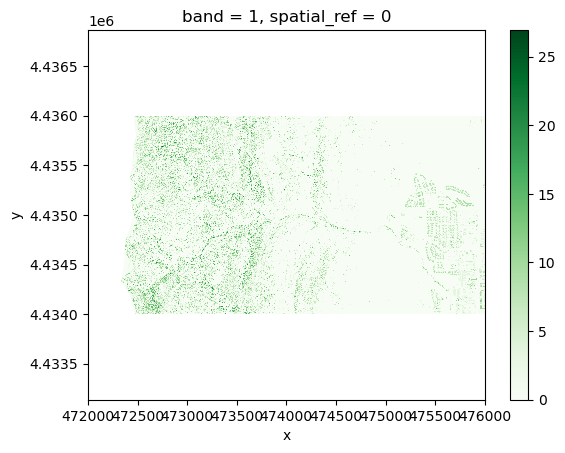

In [19]:
f, ax = plt.subplots()

pre_lidar_chm.plot(cmap = "Greens", ax = ax)

plt.axis("equal");

In [5]:
# Using with might be better because it automatically closes the file for you
# You can also get the specific stuff you want (just the data, etc.)
with rxr.open_rasterio(os.path.join(data_path, "pre_CHM.tif")) as ds:
    pre_lidar_chm = ds

print(pre_lidar_chm.rio.crs)
print(pre_lidar_chm.rio.resolution())
print(pre_lidar_chm.rio.nodata)

EPSG:32613
(1.0, -1.0)
nan


In [6]:
# ### Raster classification

# Rasters can be classified in order to give a more simplified view of the dataset, which can aid understanding
# rasters can be easily binned using np.digitize
class_bins = [0, 2, 7, 12, 30]

x = np.array([0.2, 6.4, 3.0, 1.6])
bins = np.array([0.0, 1.0, 2.5, 4.0, 10.0])
inds = np.digitize(x, bins)
inds

array([1, 4, 3, 2], dtype=int64)

In [7]:
# note that anything that's outside of the range of the data is given a value as well 
# This value is 0 for values LOWER than the range, and 5 for values HIGHER than the range
# np.nan and masked values count as being HIGHER than the range.
x = np.array([np.nan, 1, 4, 40, 27, -5])

masked_x = np.ma.MaskedArray(x, mask = np.isnan(x))

inds = np.digitize(x, class_bins)

masked_inds = np.digitize(masked_x, class_bins)

print(inds)
print(masked_inds)

[5 1 2 5 4 0]
[5 1 2 5 4 0]


In [8]:
# note that if you call np.digitize on the rioxarray object, you'll get a numpy array back
classified_pre_chm = np.digitize(pre_lidar_chm, class_bins)

type(classified_pre_chm)

numpy.ndarray

In [9]:
# Instead of doing this, we need to use xr.apply_ufunc()
# Apply a vectorized function for unlabeled arrays on xarray objects.

# The function will be mapped over the data variable(s) of the input
# arguments using xarray's standard rules for labeled computation, including
# alignment, broadcasting, looping over GroupBy/Dataset variables, and
# merging of coordinates.

import xarray as xr

classified_pre_chm = xr.apply_ufunc(np.digitize, pre_lidar_chm, class_bins)

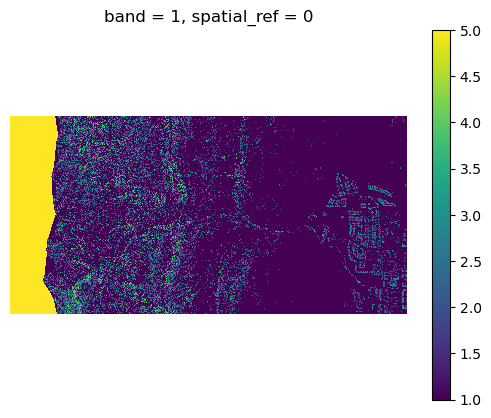

In [10]:
classified_pre_chm.plot()
plt.axis("equal")
plt.axis("off");

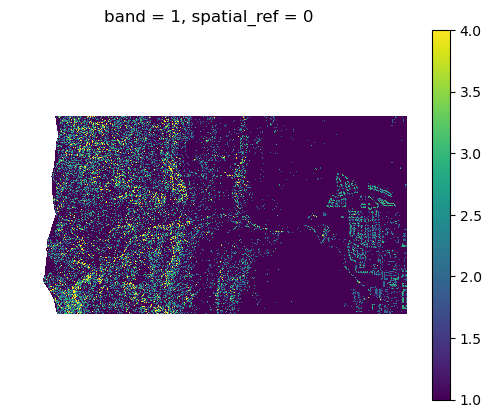

In [11]:
# Note that np.nan has been classified as 5. We should get rid of that
classified_pre_chm_clean = classified_pre_chm.where(classified_pre_chm != 5, np.nan)

classified_pre_chm_clean.plot()
plt.axis("equal")
plt.axis("off");

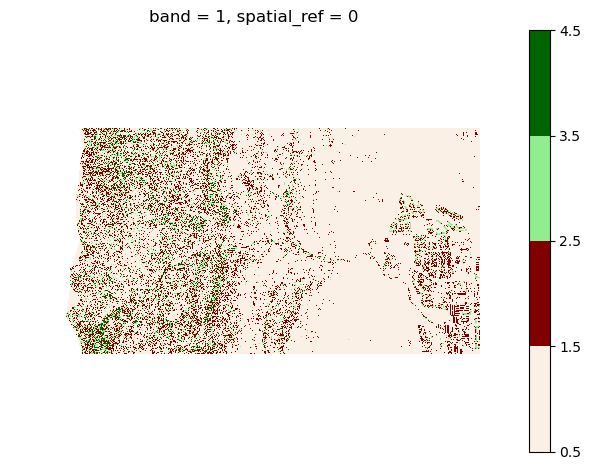

In [12]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm

# Custom colorbar
colors = ['linen', 'maroon', 'lightgreen', 'darkgreen']
bins = [.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, 
                    len(colors))

classified_pre_chm_clean.plot(cmap = cmap, norm = norm) # add_colorbar = False
plt.axis("equal")
plt.axis("off")
plt.tight_layout();

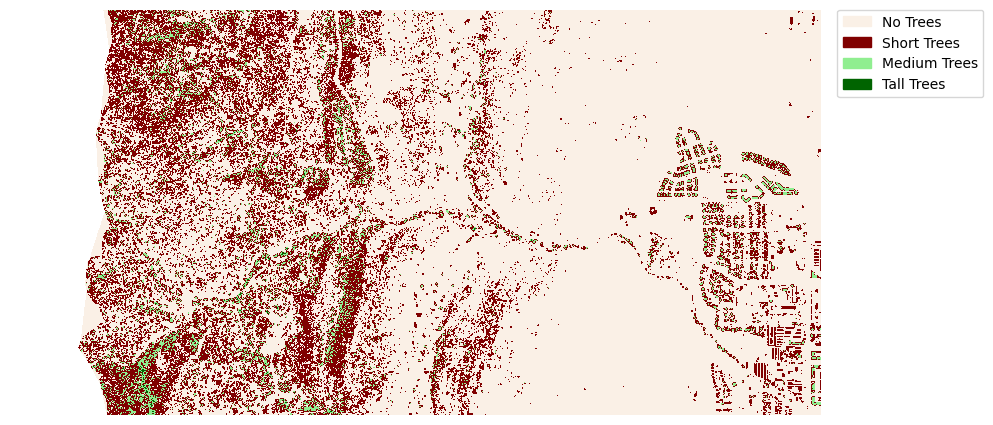

In [13]:
# This legend is still not great - let's use something else:
# MUCH better
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize = (10,5))
ep.plot_bands(classified_pre_chm_clean, cmap = cmap, norm = norm, cbar = False, ax = ax)

colors = ['linen', 'maroon', 'lightgreen', 'darkgreen']
forest = ['No Trees', "Short Trees", "Medium Trees", "Tall Trees"]

patches = [mpatches.Patch(color=colors[i], label = forest[i]) for i in range(4)]
plt.legend(handles=patches , bbox_to_anchor=(1.02, 1), loc = 2, borderaxespad=0. )


plt.axis("off")
plt.tight_layout();

In [14]:
# Practice saving rasters
# Set the nodata value to 255

classified_pre_chm_to_save = classified_pre_chm_clean.where(np.invert(np.isnan(classified_pre_chm_clean)), 255)

classified_pre_chm_to_save.rio.set_nodata(255)

# WORKED - 7MB compared to the 30MB if using float32
classified_pre_chm_to_save.rio.to_raster(os.path.join(data_path, "classified_pre_chm.tif"), dtype = np.uint8)

In [18]:
# Opening with masked automatically loads in the data as float32
with rxr.open_rasterio(os.path.join(data_path, "classified_pre_chm.tif")) as ds:
    test = ds

In [20]:
test

<xarray.DataArray (band: 1, y: 2000, x: 4000)>
array([[[255, 255, ...,   1,   1],
        [255, 255, ...,   1,   1],
        ...,
        [255, 255, ...,   1,   1],
        [255, 255, ...,   1,   1]]], dtype=uint8)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
# Plot change over time betwee CHM before and after the flood
# we already have pre_lidar_chm - let's grab post_lidar_chm
with rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/post-flood/lidar/post_DSM.tif") as ds:
    post_DSM = ds
    
with rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/post-flood/lidar/post_DTM.tif") as ds:
    post_DTM = ds
    
post_chm = post_DSM - post_DTM

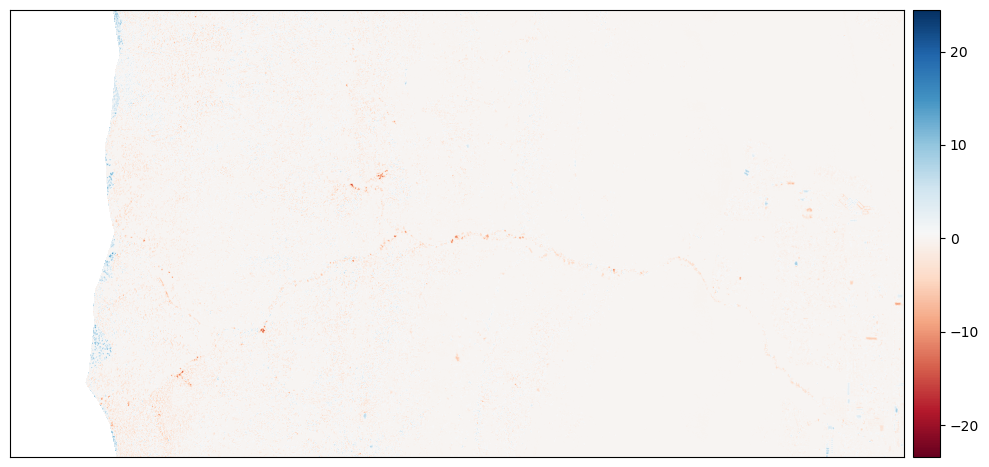

<Axes: >

In [25]:
# In chm_change, the + values = increase in height, - values = decrease in height
chm_change = post_chm - pre_lidar_chm

ep.plot_bands(chm_change, cmap = "RdBu")

-23.429932
24.45996


(array([3.000000e+00, 8.000000e+00, 3.100000e+01, 7.900000e+01,
        1.580000e+02, 3.360000e+02, 6.530000e+02, 1.270000e+03,
        2.300000e+03, 4.041000e+03, 6.871000e+03, 1.143100e+04,
        1.854700e+04, 2.922200e+04, 4.540900e+04, 7.105200e+04,
        1.109060e+05, 1.759780e+05, 3.008340e+05, 5.541995e+06,
        3.311330e+05, 1.851200e+05, 1.163820e+05, 7.483700e+04,
        4.791800e+04, 3.124700e+04, 2.012100e+04, 1.273300e+04,
        7.635000e+03, 4.468000e+03, 2.495000e+03, 1.364000e+03,
        6.160000e+02, 3.080000e+02, 1.270000e+02, 6.500000e+01,
        1.400000e+01, 1.100000e+01, 6.000000e+00, 4.000000e+00]),
 array([-23.42993164, -22.23268509, -21.03543663, -19.83819008,
        -18.64094162, -17.44369507, -16.24644852, -15.04920006,
        -13.85195351, -12.654706  , -11.4574585 , -10.26021099,
         -9.06296349,  -7.86571646,  -6.66846943,  -5.47122192,
         -4.27397442,  -3.07672739,  -1.87948   ,  -0.68223268,
          0.51501465,   1.71226192,   

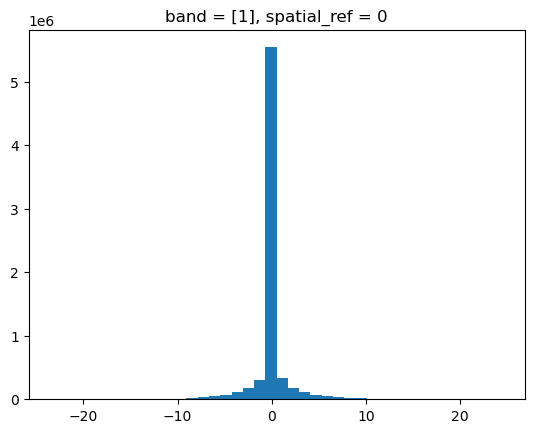

In [28]:
# Investigate summary statistics
print(np.nanmin(chm_change))
print(np.nanmax(chm_change))

# A majority of the land surface did not change (between -0.5 to 0.5 meters)
chm_change.plot.hist(bins = 40)

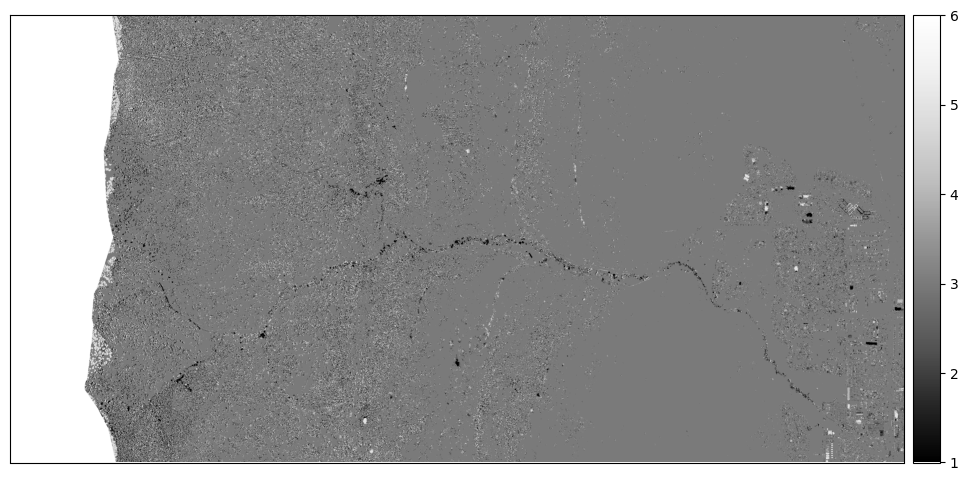

<Axes: >

In [30]:
class_bins = [-25, -3, -0.5, 0.5, 3, 25]

classified_change = xr.apply_ufunc(np.digitize, chm_change, class_bins)

# 6 is the nodata value - change to np.nan
ep.plot_bands(classified_change)

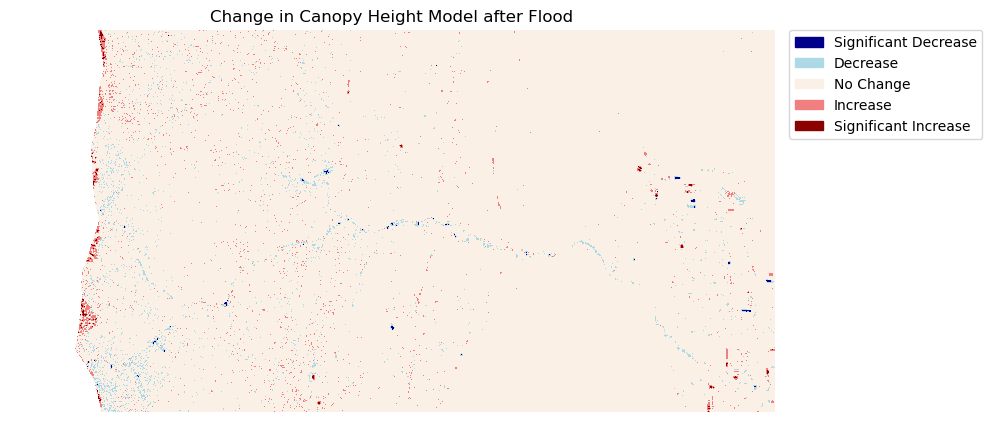

In [60]:
classified_change_clean = classified_change.where(classified_change != 6, np.nan)

colors = ['darkblue', 'lightblue', 'linen', 'lightcoral', 'darkred']
forest = ['Significant Decrease', "Decrease", "No Change", "Increase", "Significant Increase"]

# Custom colorbar
bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, 
                    len(colors))

f, ax = plt.subplots(figsize = (10,5))
ep.plot_bands(classified_change_clean, cmap = cmap, norm = norm, cbar = False, ax = ax)

patches = [mpatches.Patch(color=colors[i], label = forest[i]) for i in range(5)]
plt.legend(handles=patches , bbox_to_anchor=(1.02, 1), loc = 2, borderaxespad=0. )

plt.title("Change in Canopy Height Model after Flood")
plt.axis("off")
plt.tight_layout();

In [36]:
# Set the nodata value to 255
classified_change_save = classified_change_clean.where(np.invert(np.isnan(classified_change_clean)), 0)

classified_change_save.rio.set_nodata(0)

# WORKED - 7MB compared to the 30MB if using float32
classified_change_save.rio.to_raster(os.path.join(data_path, "classified_chm_change.tif"), dtype = np.uint8)

In [39]:
with rxr.open_rasterio(os.path.join(data_path, "classified_chm_change.tif"), masked = True) as ds:
    test = ds

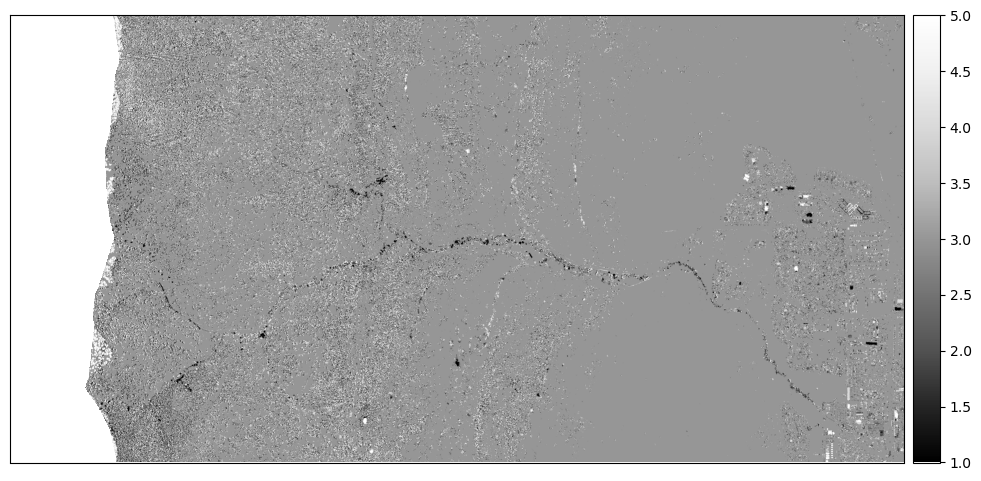

<Axes: >

In [40]:
ep.plot_bands(test)

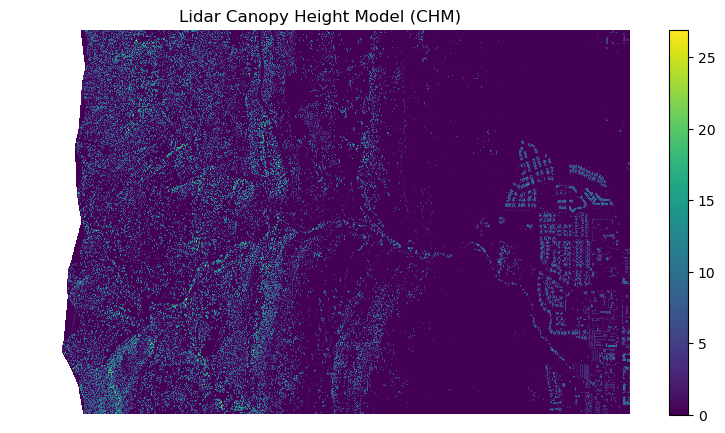

In [42]:
lidar_chm_path = os.path.join("colorado-flood", 
                              "spatial",
                              "outputs",
                              "pre_CHM.tif")

lidar_chm_im = rxr.open_rasterio(lidar_chm_path,
                                 masked=True).squeeze()

f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_im.plot.imshow()
ax.set(title="Lidar Canopy Height Model (CHM)")

ax.set_axis_off()
plt.show()

<Axes: >

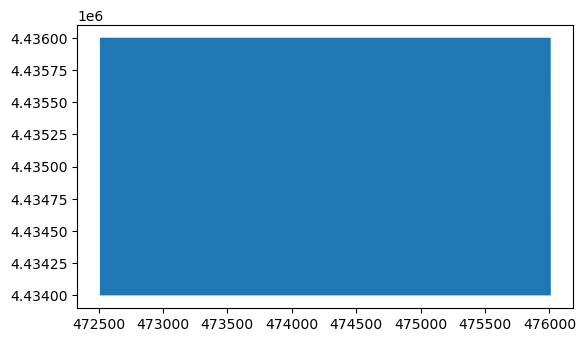

In [43]:
# In most cases, you want to crop your data to a vector extent
aoi = os.path.join("colorado-flood",
                   "spatial",
                   "boulder-leehill-rd",
                   "clip-extent.shp")

# Open crop extent (your study area extent boundary)
crop_extent = gpd.read_file(aoi)

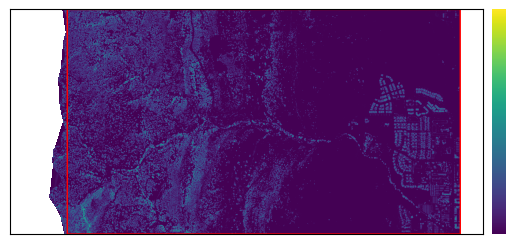

In [48]:
# Plot on top of each other
# If the CRSs are off, this won't plot properly
f, ax = plt.subplots()

chm_extent = plotting_extent(lidar_chm_im.squeeze(), transform = lidar_chm_im.rio.transform())

ep.plot_bands(lidar_chm_im, ax = ax, extent = chm_extent, cmap = "viridis")
crop_extent.plot(color = "none", edgecolor = "red", ax = ax)

plt.axis("off");

In [51]:
# If you want to crop the data you can use the rio.clip function. When you clip the data, you can then export it and share 
# it with colleagues. Or use it in another analysis.

# To perform the clip you:

#     Open the raster dataset that you wish to crop using xarray or rioxarray.
#     Open your shapefile as a geopandas object.
#     Crop the data using the .clip() function.

# .clip has several parameters that you can consider including

#     drop = True : The default. setting it will drop all pixels outside of the clip extent
#     invert = False : The default. If set to true it will clip all data INSIDE of the clip extent
#     crs : if your shapefile is in a different CRS than the raster data, pass the CRS to ensure the data are clipped correctly.

# Note that rio.clip takes in geometries - you'll need to provide the "geometry" column of the geodataframe
chm_clipped = lidar_chm_im.rio.clip(crop_extent.geometry)

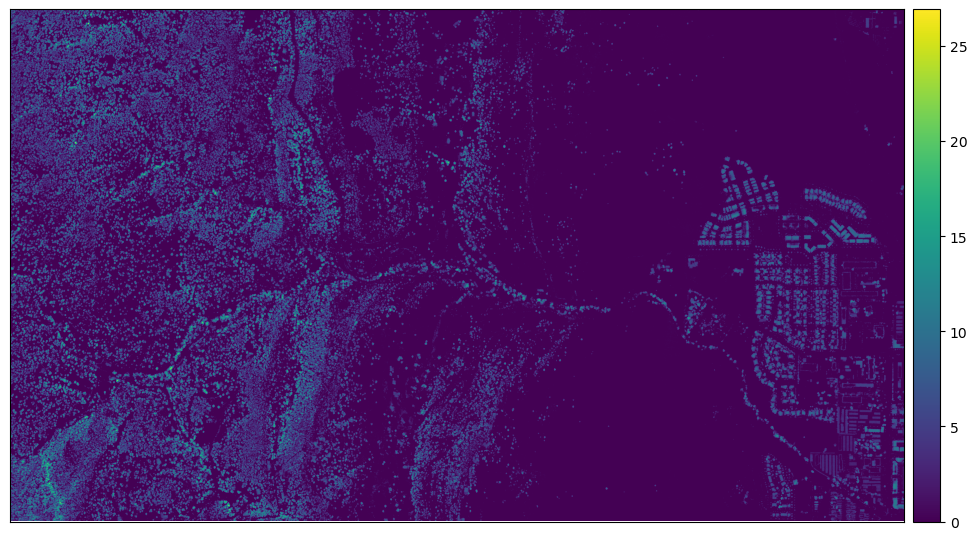

<Axes: >

In [53]:
ep.plot_bands(chm_clipped, cmap = "viridis")

In [55]:
# Create classified dtm model

dtm_pre = rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif", masked = True)
dtm_post = rxr.open_rasterio("colorado-flood/spatial/boulder-leehill-rd/post-flood/lidar/post_DTM.tif", masked = True)

# In dtm_change, the + values = increase in height, - values = decrease in height
dtm_change = dtm_post - dtm_pre

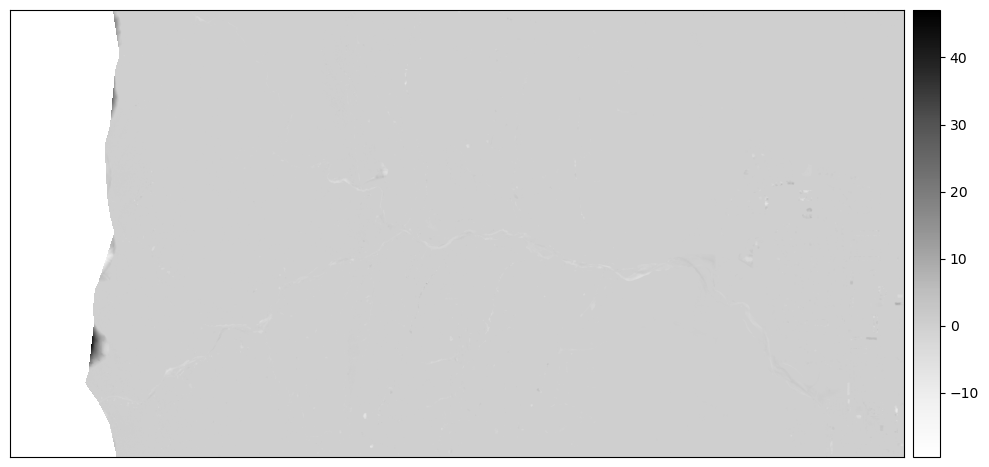

<Axes: >

In [56]:
# Map of DTM change
ep.plot_bands(dtm_change, cmap = "Greys")

-19.609985
47.100098


(array([2.000000e+00, 1.600000e+01, 3.200000e+01, 7.800000e+01,
        1.290000e+02, 2.350000e+02, 4.110000e+02, 5.960000e+02,
        1.121000e+03, 3.717000e+03, 3.173800e+04, 6.947309e+06,
        1.447230e+05, 7.747000e+03, 3.676000e+03, 2.737000e+03,
        1.862000e+03, 1.664000e+03, 1.453000e+03, 1.168000e+03,
        1.042000e+03, 9.270000e+02, 8.230000e+02, 5.760000e+02,
        5.150000e+02, 4.950000e+02, 4.600000e+02, 3.280000e+02,
        2.780000e+02, 2.370000e+02, 2.220000e+02, 2.340000e+02,
        2.040000e+02, 2.130000e+02, 1.950000e+02, 1.570000e+02,
        1.520000e+02, 1.380000e+02, 8.700000e+01, 3.100000e+01]),
 array([-19.60998535, -17.94223404, -16.27448082, -14.60672951,
        -12.93897724, -11.27122498,  -9.60347271,  -7.93572092,
         -6.26796865,  -4.60021687,  -2.9324646 ,  -1.26471257,
          0.40303954,   2.07079172,   3.73854375,   5.40629578,
          7.07404804,   8.74180031,  10.40955162,  12.07730389,
         13.74505615,  15.41280842,  1

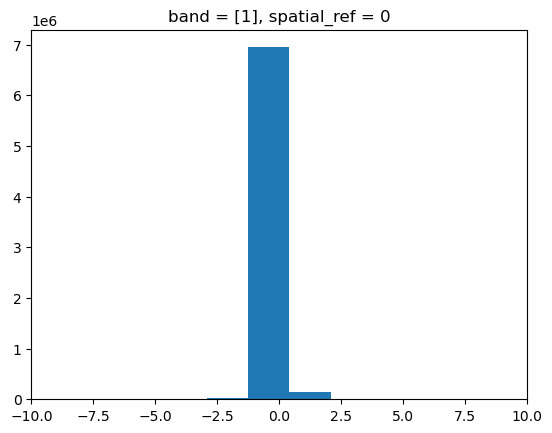

In [61]:
# Classify the DTM change
print(np.nanmin(dtm_change))
print(np.nanmax(dtm_change))
dtm_change.plot.hist(bins = 40, xlim = (-10, 10))

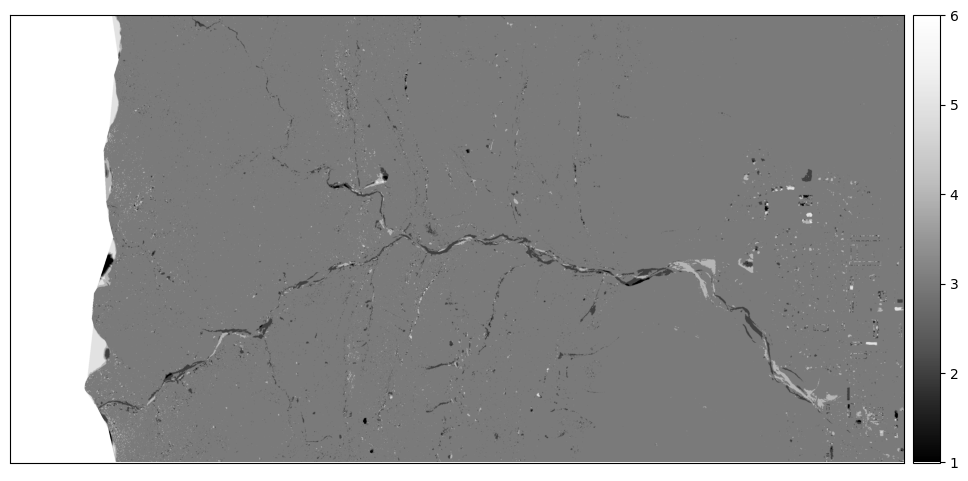

<Axes: >

In [62]:
dtm_class_bin = [-20, -3, -0.5, 0.5, 3, 50]

classified_dtm_change = xr.apply_ufunc(np.digitize, dtm_change, dtm_class_bin)

ep.plot_bands(classified_dtm_change)

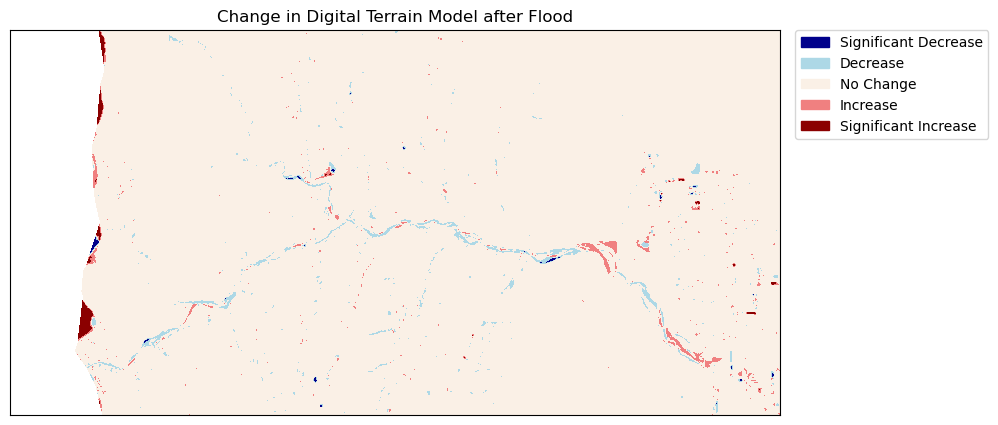

In [65]:
# Set nodata
classified_dtm_change_clean = classified_dtm_change.where(classified_dtm_change != 6, np.nan)

colors = ['darkblue', 'lightblue', 'linen', 'lightcoral', 'darkred']
forest = ['Significant Decrease', "Decrease", "No Change", "Increase", "Significant Increase"]

# Custom colorbar
bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, 
                    len(colors))

f, ax = plt.subplots(figsize = (10,5))
ep.plot_bands(classified_dtm_change_clean, cmap = cmap, norm = norm, cbar = False, ax = ax)

patches = [mpatches.Patch(color=colors[i], label = forest[i]) for i in range(5)]
plt.legend(handles=patches , bbox_to_anchor=(1.02, 1), loc = 2, borderaxespad=0. )

plt.title("Change in Digital Terrain Model after Flood");

In [67]:
classified_dtm_change.rio.set_nodata(6)

classified_dtm_change.rio.to_raster("colorado-flood/spatial/outputs/classified_dtm_change.tif", dtype = np.uint8)

In [68]:
# Crop the chm_change and DTM_change rasters
with rxr.open_rasterio("colorado-flood/spatial/outputs/classified_chm_change.tif") as ds:
    classified_chm_change = ds
    
with rxr.open_rasterio("colorado-flood/spatial/outputs/classified_dtm_change.tif") as ds:
    classified_dtm_change = ds

In [69]:
chm_change_clipped = classified_chm_change.rio.clip(crop_extent.geometry)

dtm_change_clipped = classified_dtm_change.rio.clip(crop_extent.geometry)

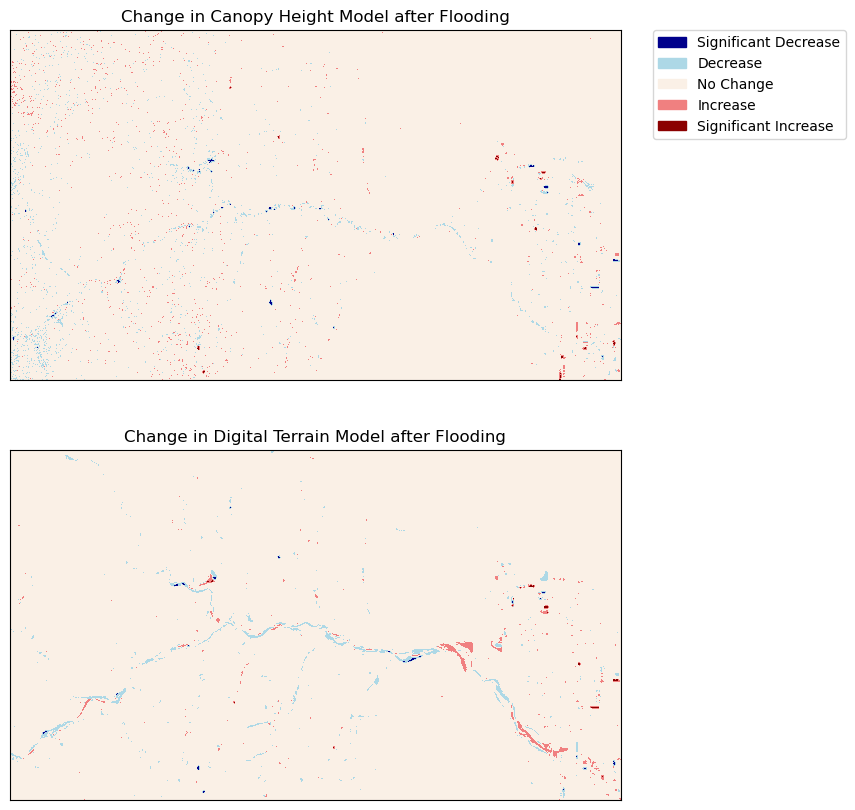

In [77]:
f, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10,10))

colors = ['darkblue', 'lightblue', 'linen', 'lightcoral', 'darkred']
forest = ['Significant Decrease', "Decrease", "No Change", "Increase", "Significant Increase"]

# Custom colorbar
bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, 
                    len(colors))

ep.plot_bands(chm_change_clipped, cmap = cmap, norm = norm, cbar = False, ax = ax1)
ep.plot_bands(dtm_change_clipped, cmap = cmap, norm = norm, cbar = False, ax = ax2)

ax1.set_title("Change in Canopy Height Model after Flooding")
ax2.set_title("Change in Digital Terrain Model after Flooding")

# The visualization shows that there were some changes in the way that some of the buildings were classified
# It seems post-flooding some of the buildings were included in the DTM

patches = [mpatches.Patch(color=colors[i], label = forest[i]) for i in range(5)]
f.legend(handles=patches , bbox_to_anchor=(.85, .88), loc = 2, borderaxespad=0. )

In [83]:
### Reprojecting Rasters

# Proceed with caution when you are reprojecting raster data. Often it’s best to reproject your vector data as
# reprojecting a raster means that the entire dataset are interpolated and cast into a new grid system. This adds error
# and uncertainty to your analysis. There are times when you need to reproject your data. However, consider carefully
# whether you need to do this, before implementimg it in an analysis.

# Here, we are going to try and reproject raster data to fit this vector layer
boulder_roads = gpd.read_file(
    "https://opendata.arcgis.com/datasets/5388d74deeb8450e8b0a45a542488ec8_0.geojson"
)

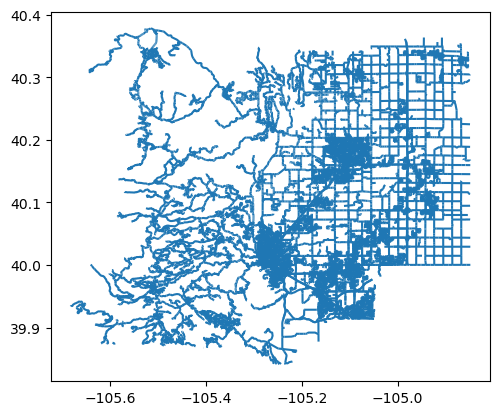

In [85]:
boulder_roads.plot()

boulder_roads.to_file("colorado-flood/spatial/outputs/boulder_roads.geojson", driver = "GeoJSON")

In [86]:
# This has a geographic coordinate system (as you can see from the axes)
boulder_roads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

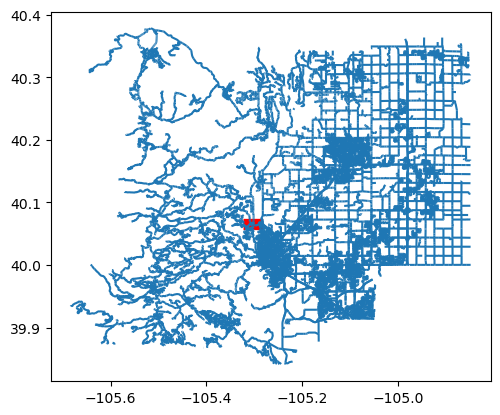

In [88]:
# Adjust our crop_extent to WGS84
crop_extent_geog = crop_extent.to_crs("EPSG:4326")

f, ax = plt.subplots()
boulder_roads.plot(ax = ax)
crop_extent_geog.plot(ax = ax, color = "red")

<Axes: >

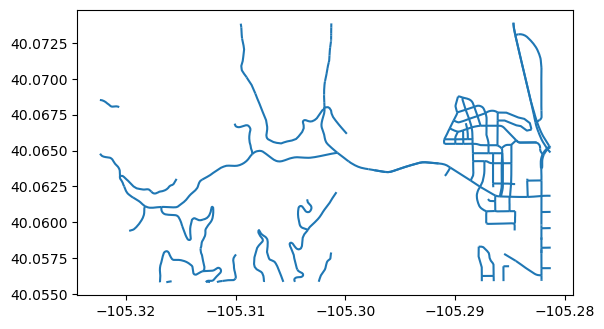

In [89]:
# Crop the roads to the appropriate extent
roads_cropped = gpd.clip(boulder_roads, crop_extent_geog)

roads_cropped.plot()

In [90]:
# Open up a DTM
lidar_dem_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

lidar_dem = rxr.open_rasterio(lidar_dem_path,
                              masked=True).squeeze()

# Check the CRS - its projected CRS
# Clearly plotting these will not work
lidar_dem.rio.crs

CRS.from_epsg(32613)

In [92]:
# We can reproject raster data in rioxarray using the following
lidar_dem_geog = lidar_dem.rio.reproject("EPSG:4326")

In [93]:
lidar_dem_geog.rio.crs

CRS.from_epsg(4326)

<Axes: >

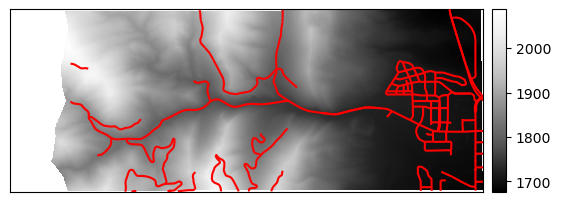

In [103]:
# Plot together
f, ax = plt.subplots()

lidar_extent = plotting_extent(lidar_dem_geog, lidar_dem_geog.rio.transform())

roads_cropped.plot(ax = ax, zorder = 4, color = "red")
ep.plot_bands(lidar_dem_geog, ax = ax, extent = lidar_extent)